In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhisekhbhagat","key":"64f8eff816fcb19176f696dfefb22723"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download chetankv/dogs-cats-images

Dataset URL: https://www.kaggle.com/datasets/chetankv/dogs-cats-images
License(s): CC0-1.0
 98% 426M/435M [00:03<00:00, 130MB/s]
100% 435M/435M [00:04<00:00, 113MB/s]


In [7]:
import zipfile
with zipfile.ZipFile("dogs-cats-images.zip", 'r') as zip_ref:
    zip_ref.extractall("dog-cat-dataset")


In [8]:
from torch import nn
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from  torch import optim
from torchvision import transforms, utils, models

from collections import OrderedDict
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
data_dir = "/content/dog-cat-dataset/dataset/"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((280,280)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([
                                transforms.Resize((280,280)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])

train_data = datasets.ImageFolder(data_dir + 'training_set', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + 'test_set', transform=test_transforms)

In [10]:
for image,label in train_data:
    print(image.shape)
    break

torch.Size([3, 280, 280])


In [11]:
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64,shuffle=True)

In [12]:
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    std = [0.5,0.5,0.5]
    mean = [0.5,0.5,0.5]
    img = img*std + mean
    return img


def plot_10():
        iter_ = iter(trainloader)
        images,labels = next(iter_)
        an_ = {'0':'cat','1':'dog'}

        plt.figure(figsize=(20,10))
        for idx in range(10):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()

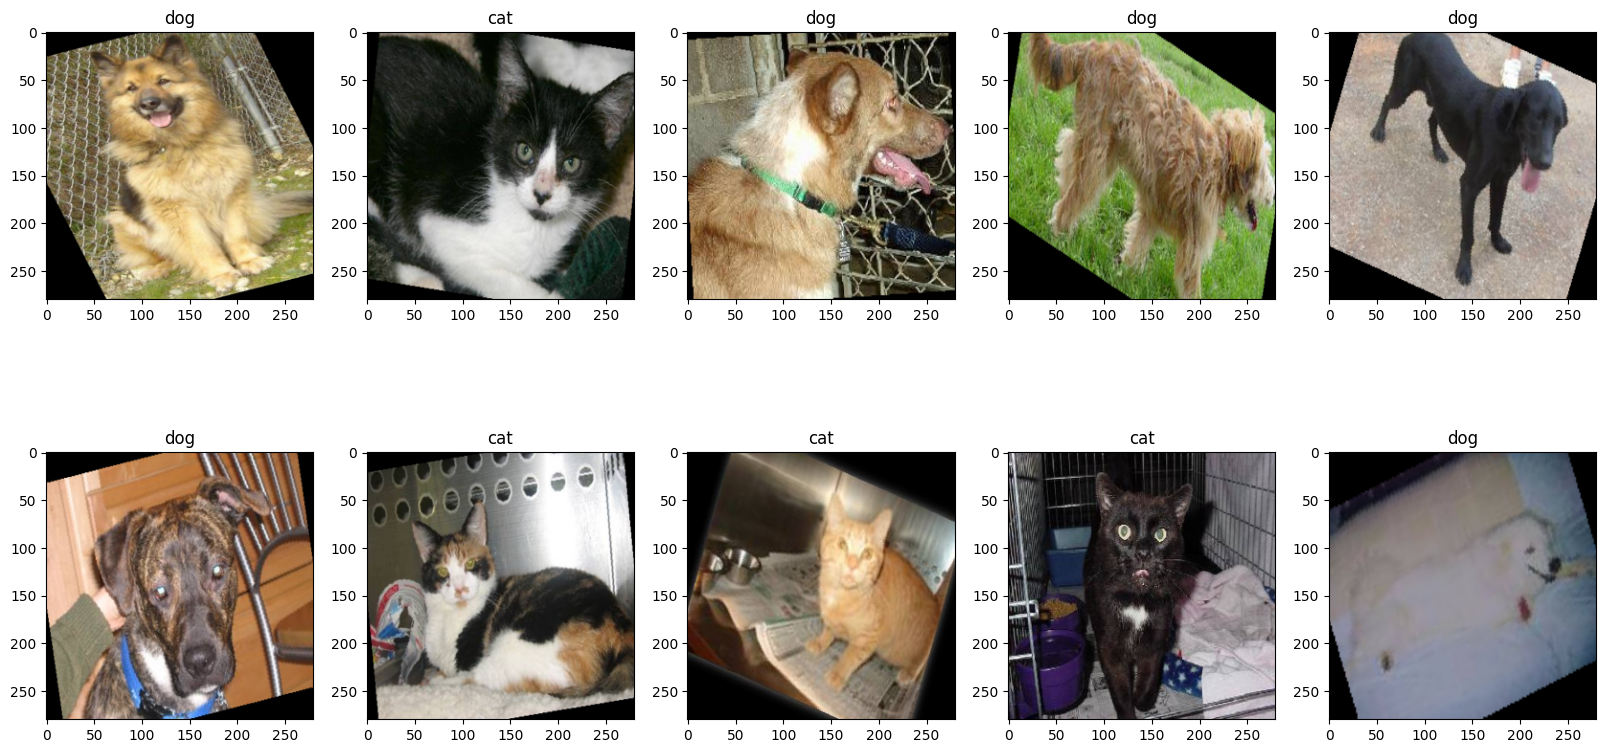

In [13]:
plot_10()

In [14]:
model =  models.resnet18(pretrained=True).to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
from torch import nn
class Dc_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512,120)
        self.linear2=nn.Linear(120,2)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [16]:
model_ = Dc_model().to(device)
model_

Dc_model(
  (linear1): Linear(in_features=512, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=2, bias=True)
)

In [19]:
model.fc = model_

In [20]:
for param in model.parameters():
        param.requires_grad = False
for param in model.fc.parameters():
        param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
train_loss = []
val_loss = []

epochs = 5

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
#       model.train()
      for image,label in trainloader:
          image = image.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred = model.forward(image)
          loss = criterion(y_pred,label)
          loss.backward() #calculate derivatives
          optimizer.step() # update parameters
          val, index_ = torch.max(y_pred,axis=1)
          running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()

      epoch_score = running_score/len(trainloader.dataset)
      epoch_loss = running_loss/len(trainloader.dataset)
      train_loss.append(epoch_loss)
      print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in testloader:
                image = image.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(image)
                loss = criterion(y_pred,label)
                running_loss += loss.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(testloader.dataset)
          epoch_loss = running_loss/len(testloader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

epoch 1/5
Training loss: 0.0022095753913745284, accuracy: 0.9425
Validation loss: 0.0008893495348747819, accuracy: 0.982
epoch 2/5
Training loss: 0.0011076989299617708, accuracy: 0.973125
Validation loss: 0.0006868639326421544, accuracy: 0.985
epoch 3/5
Training loss: 0.0009221288759727032, accuracy: 0.977125
Validation loss: 0.0007224434409290552, accuracy: 0.9865
epoch 4/5
Training loss: 0.0008767987373867072, accuracy: 0.976875
Validation loss: 0.0006907076800707727, accuracy: 0.9875
epoch 5/5
Training loss: 0.0008870666529110167, accuracy: 0.978
Validation loss: 0.0007366616014624015, accuracy: 0.985


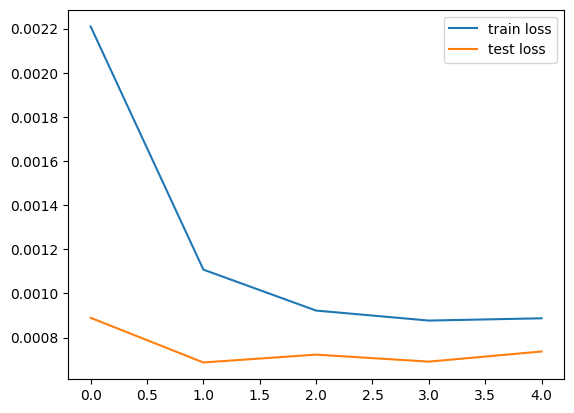

In [21]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='test loss')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), "resnet18_cat_dog_best.pth")
print("Model training completed and saved as 'resnet18_cat_dog_best.pth'")

Model training completed and saved as 'resnet18_cat_dog_best.pth'
